In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import string
import re
import os
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [2]:
def plot_conf_matrix(y_pred, y_true, title=None):
    """Helper Function to plot confustion matrix"""
    
    conf_mat = confusion_matrix(y_pred, y_true)
    df_cm = pd.DataFrame(conf_mat, index = [i for i in ["Fake", "Real"]],
                  columns = [i for i in ["Fake", "Real"]])
    plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=True, cmap="Blues")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    if title:
        plt.title(f"{title} Confusion Matrix")
    plt.show()

In [54]:
fake_news_df.iloc[80]['Text']

' Seven children died from coronavirus within one week in Karimganj (Assam, India).\t\t'

# Read in Data and Preprocess

In [211]:
true_news_df = pd.read_csv("COVID19-FNIR/COVID19-FNIR/trueNews.csv")
fake_news_df = pd.read_csv("COVID19-FNIR/COVID19-FNIR/fakeNews.csv")

In [212]:
combined.shape

(7588, 2)

In [213]:
fake_news_df.shape

(3795, 11)

In [214]:
true_news_df.shape

(3793, 7)

In [215]:
# Assign class columns and combine dataframes
fake_news_df["class"] = 0
true_news_df["class"] = 1
combined = pd.concat([fake_news_df, true_news_df], axis=0)

In [216]:
# Subset data to just contain the text field and the class field
combined = combined[["Text", "class"]].reset_index(drop=True)
# Shuffle data
combined = combined.sample(frac = 1)

In [217]:
combined['Text'] = combined['Text'].str.replace('http\S+|www.\S+', '', case=False)
combined['Text'] = combined['Text'].str.replace('pic\S+|twitter.\S+', '', case=False)
combined['Text'] = combined['Text'].str.replace('#\S+', '', case=False)
combined['Text'] = combined['Text'].str.replace('@\S+', '', case=False)
combined['Text'] = combined['Text'].str.replace('Link:\S+', '', case=False)
combined['Text'] = combined['Text'].str.replace('[ \t]+$', '', case=False)


def wordopt(text):
    """Formating of the text field """
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub("\\W"," ",text) 
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)    
    return text
combined["Text"] = combined["Text"].apply(wordopt)

In [218]:
combined[combined["class"]==1].iloc[2]["Text"]

'uk employers should pay wages of those asked to isolate by covid  trace system  minister says   '

In [219]:
# remove front and ending blank spaces
combined = combined.replace({"^\s*|\s*$":""}, regex=True) 

In [222]:
# for i in range(1000):
#     print(f"{i}: {combined[combined['class']==0].iloc[i]['Text']}")

In [223]:
combined[combined["class"]==0].iloc[1000]["Text"]

'the department of homeland security  dhs  plans to mobilize the national guard to enforce a nationwide  day quarantine'

In [224]:
combined.head()

,Text,class
4844,new report highlights geographic differences ...,1
7506,govt changes strategy to fight against covid ...,1
2612,hot weather will stop the covid pandemic,0
735,spanish politician ortega smith said i prefer...,0
6649,uk employers should pay wages of those asked t...,1


In [225]:
combined.head()

,Text,class
4844,new report highlights geographic differences ...,1
7506,govt changes strategy to fight against covid ...,1
2612,hot weather will stop the covid pandemic,0
735,spanish politician ortega smith said i prefer...,0
6649,uk employers should pay wages of those asked t...,1


In [226]:
# Set X and y variables
X = combined["Text"]
y = combined["class"]

In [227]:
# Split data into training and test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [228]:
from sklearn.feature_extraction.text import TfidfVectorizer

# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html 

vectorization = TfidfVectorizer()
X_train = vectorization.fit_transform(X_train)
X_test = vectorization.transform(X_test)

# Model 1: Naive Bayes Model

In [229]:
from sklearn.naive_bayes import MultinomialNB


nb_model = MultinomialNB()
# Fit model 
nb_model.fit(X_train, y_train)
# Predict 
y_pred = nb_model.predict(X_test)

In [230]:
print(f"Test Accuracy: {accuracy_score(y_test, y_pred)}")

Test Accuracy: 0.8892988929889298


In [231]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.89      0.89       961
           1       0.88      0.89      0.89       936

    accuracy                           0.89      1897
   macro avg       0.89      0.89      0.89      1897
weighted avg       0.89      0.89      0.89      1897



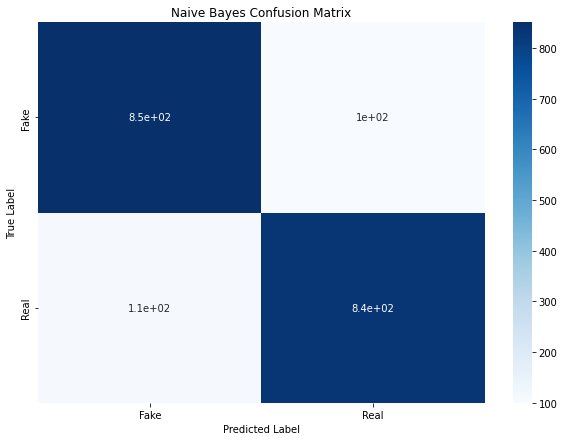

In [232]:
plot_conf_matrix(y_pred, y_test, title="Naive Bayes")

In [233]:
# 
params = {
    "alpha": [0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1, 1.5, 2, 3, 5, 10],
    "fit_prior": (True, False),
}
gs_clf = GridSearchCV(MultinomialNB(), params, n_jobs=-1)
gs_clf = gs_clf.fit(X_train, y_train)

In [234]:
# gs_clf.cv_results_

In [235]:
y_pred = gs_clf.predict(X_test)

In [236]:
print(f"Test Accuracy: {accuracy_score(y_test, y_pred)}")

Test Accuracy: 0.8914074855034264


In [237]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.89      0.89       961
           1       0.89      0.89      0.89       936

    accuracy                           0.89      1897
   macro avg       0.89      0.89      0.89      1897
weighted avg       0.89      0.89      0.89      1897



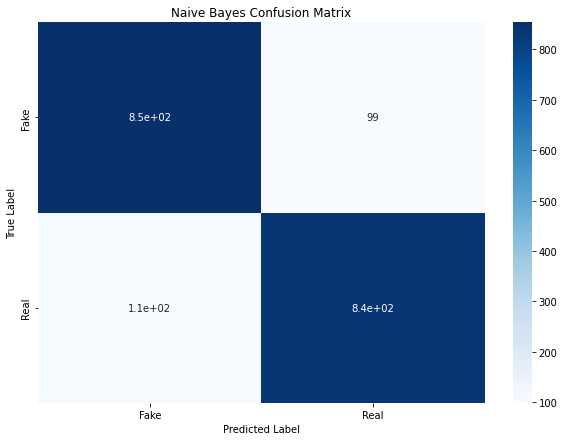

In [238]:
plot_conf_matrix(y_pred, y_test, title="Naive Bayes")

# Model 2: Gradient Boosting Classifier

In [239]:
from sklearn.ensemble import GradientBoostingClassifier

gbt_model = GradientBoostingClassifier()
# Fit model 
gbt_model.fit(X_train, y_train)
# Predict 
y_pred = gbt_model.predict(X_test)

In [240]:
print(f"Test Accuracy: {accuracy_score(y_test, y_pred)}")

Test Accuracy: 0.8508170795993675


In [241]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.83      0.85       961
           1       0.83      0.87      0.85       936

    accuracy                           0.85      1897
   macro avg       0.85      0.85      0.85      1897
weighted avg       0.85      0.85      0.85      1897



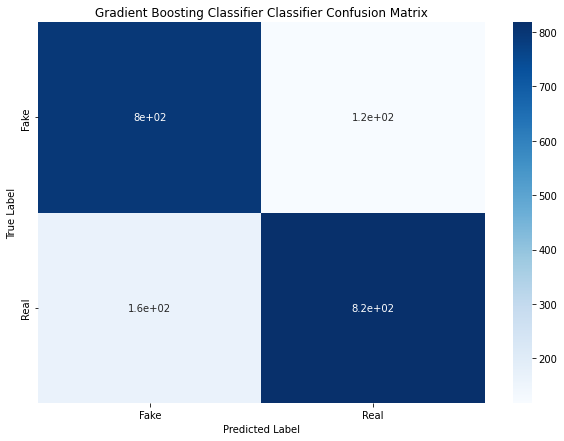

In [242]:
plot_conf_matrix(y_pred, y_test, title="Gradient Boosting Classifier Classifier")

In [243]:
%%time
params = {
    "loss": ["deviance", "exponential"],
    "learning_rate": [0.001, 0.01, 0.1, 1, 2],
    "n_estimators": [10, 50, 100],
    "subsample": [0.5, 0.75, 1.0],
}

gs_clf = GridSearchCV(GradientBoostingClassifier(), params, n_jobs=-1, scoring='accuracy', verbose=10)
  
gs_clf = gs_clf.fit(X_train, y_train)
# Predict 
y_pred = gs_clf.predict(X_test)

Fitting 5 folds for each of 90 candidates, totalling 450 fits
[CV 1/5; 3/90] START learning_rate=0.001, loss=deviance, n_estimators=10, subsample=1.0
[CV 1/5; 3/90] END learning_rate=0.001, loss=deviance, n_estimators=10, subsample=1.0;, score=0.827 total time=   0.5s
[CV 2/5; 5/90] START learning_rate=0.001, loss=deviance, n_estimators=50, subsample=0.75
[CV 2/5; 5/90] END learning_rate=0.001, loss=deviance, n_estimators=50, subsample=0.75;, score=0.839 total time=   2.1s
[CV 4/5; 7/90] START learning_rate=0.001, loss=deviance, n_estimators=100, subsample=0.5
[CV 4/5; 7/90] END learning_rate=0.001, loss=deviance, n_estimators=100, subsample=0.5;, score=0.831 total time=   3.8s
[CV 2/5; 10/90] START learning_rate=0.001, loss=exponential, n_estimators=10, subsample=0.5
[CV 2/5; 10/90] END learning_rate=0.001, loss=exponential, n_estimators=10, subsample=0.5;, score=0.825 total time=   0.3s
[CV 4/5; 10/90] START learning_rate=0.001, loss=exponential, n_estimators=10, subsample=0.5
[CV 4/

In [246]:
print(f"Test Accuracy: {accuracy_score(y_test, y_pred)}")

Test Accuracy: 0.8687401159725883


In [247]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.87      0.87       961
           1       0.86      0.87      0.87       936

    accuracy                           0.87      1897
   macro avg       0.87      0.87      0.87      1897
weighted avg       0.87      0.87      0.87      1897



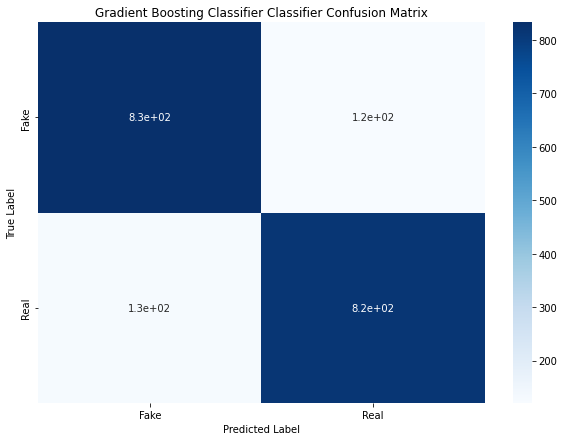

In [248]:
plot_conf_matrix(y_pred, y_test, title="Gradient Boosting Classifier Classifier")

# Model 3: Random Forest Classifier

In [249]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier()
# Fit model 
rf_model.fit(X_train, y_train)
# Predict 
y_pred = rf_model.predict(X_test)

In [250]:
params = {
    "n_estimators": [10, 50, 100, 200],
    "min_samples_leaf": [1, 2, 4],
}
gs_clf = GridSearchCV(RandomForestClassifier(), params, n_jobs=-1)
gs_clf = gs_clf.fit(X_train, y_train)
# Predict 
y_pred = gs_clf.predict(X_test)

In [251]:
print(f"Test Accuracy: {accuracy_score(y_test, y_pred)}")

Test Accuracy: 0.9109119662625198


In [252]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.91      0.91       961
           1       0.90      0.92      0.91       936

    accuracy                           0.91      1897
   macro avg       0.91      0.91      0.91      1897
weighted avg       0.91      0.91      0.91      1897



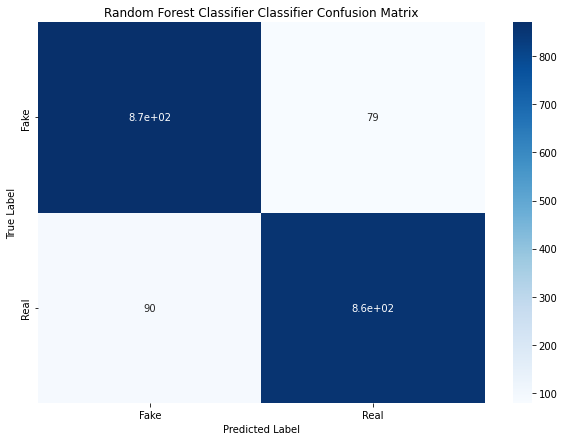

In [253]:
plot_conf_matrix(y_pred, y_test, title="Random Forest Classifier Classifier")

# LSTM

In [45]:
max_tokens = 30
X_train = np.array(X_train)
encoder = tf.keras.layers.TextVectorization(max_tokens=max_tokens)
encoder.adapt(X_train)

vocab_size = len(encoder.get_vocabulary())

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type csr_matrix).


[CV 2/5; 78/90] START learning_rate=2, loss=deviance, n_estimators=50, subsample=1.0
[CV 2/5; 78/90] END learning_rate=2, loss=deviance, n_estimators=50, subsample=1.0;, score=0.991 total time=   2.5s
[CV 4/5; 80/90] START learning_rate=2, loss=deviance, n_estimators=100, subsample=0.75
[CV 4/5; 80/90] END learning_rate=2, loss=deviance, n_estimators=100, subsample=0.75;, score=0.987 total time=   4.1s
[CV 2/5; 86/90] START learning_rate=2, loss=exponential, n_estimators=50, subsample=0.75
[CV 2/5; 86/90] END learning_rate=2, loss=exponential, n_estimators=50, subsample=0.75;, score=0.991 total time=   2.2s
[CV 4/5; 88/90] START learning_rate=2, loss=exponential, n_estimators=100, subsample=0.5
[CV 4/5; 88/90] END learning_rate=2, loss=exponential, n_estimators=100, subsample=0.5;, score=0.990 total time=   3.0s

[CV 3/5; 72/90] END learning_rate=1, loss=exponential, n_estimators=100, subsample=1.0;, score=0.997 total time=   5.1s
[CV 4/5; 78/90] START learning_rate=2, loss=deviance, 

In [36]:
###
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dropout, MaxPooling1D, Flatten
import nltk
import re
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split

In [37]:
# Set X and y variables
X = combined[["Text"]]
y = combined[["class"]]

In [38]:
voc_size=30

In [39]:
X_copy=X.copy()
X_copy.reset_index(inplace=True)

In [40]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/kavi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [41]:
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
corpus = []
for i in range(0, len(X_copy)):
    review = re.sub('[^a-zA-Z]', ' ', X_copy['Text'][i])
    review = review.lower()
    review = review.split()

    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)
# corpus

In [42]:
onehot_repr = [one_hot(words,voc_size)for words in corpus] 

In [63]:
sent_length=20
embedded_docs=pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)
embedded_docs[0]

array([ 3, 20, 11, 27,  5, 15,  5, 29,  8,  5, 26, 16, 10, 29, 24,  6, 19,
       11,  8, 20], dtype=int32)

In [64]:
X_final=np.array(embedded_docs)
y_final=np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.33, random_state=42, stratify=y)

In [65]:
voc_size

30

In [66]:
embedding_vector_features=40
model1=Sequential()
model1.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model1.add(Dropout(0.2))
model1.add(LSTM(1000))
model1.add(Dropout(0.2))
model1.add(Dense(1, activation='sigmoid'))
model1.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model1.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 20, 40)            1200      
                                                                 
 dropout_2 (Dropout)         (None, 20, 40)            0         
                                                                 
 lstm_1 (LSTM)               (None, 1000)              4164000   
                                                                 
 dropout_3 (Dropout)         (None, 1000)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1001      
                                                                 
Total params: 4,166,201
Trainable params: 4,166,201
Non-trainable params: 0
_________________________________________________________________
None


In [67]:
history = model1.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=20,batch_size=256)

Epoch 1/20
20/20 [==============================] - 2s 31ms/step - loss: 0.4810 - accuracy: 0.7826 - val_loss: 0.3509 - val_accuracy: 0.8535
Epoch 2/20
20/20 [==============================] - 0s 18ms/step - loss: 0.3320 - accuracy: 0.8635 - val_loss: 0.3071 - val_accuracy: 0.8663
Epoch 3/20
20/20 [==============================] - 0s 18ms/step - loss: 0.2838 - accuracy: 0.8845 - val_loss: 0.2577 - val_accuracy: 0.9030
Epoch 4/20
20/20 [==============================] - 0s 17ms/step - loss: 0.2323 - accuracy: 0.9073 - val_loss: 0.2170 - val_accuracy: 0.9166
Epoch 5/20
20/20 [==============================] - 0s 18ms/step - loss: 0.1966 - accuracy: 0.9266 - val_loss: 0.2178 - val_accuracy: 0.9158
Epoch 6/20
20/20 [==============================] - 0s 17ms/step - loss: 0.1652 - accuracy: 0.9384 - val_loss: 0.1434 - val_accuracy: 0.9429
Epoch 7/20
20/20 [==============================] - 0s 18ms/step - loss: 0.1405 - accuracy: 0.9502 - val_loss: 0.1374 - val_accuracy: 0.9461
Epoch 8/20
20

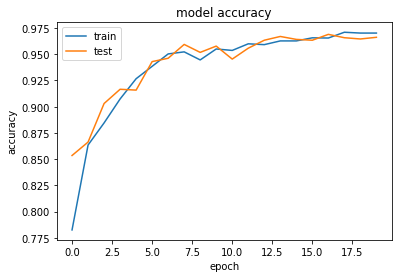

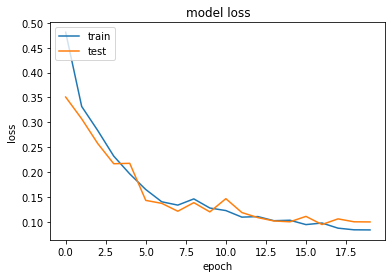

In [68]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [69]:
# Building the CNN Model
model = Sequential()      # initilaizing the Sequential nature for CNN model
# Adding the embedding layer which will take in maximum of 450 words as input and provide a 32 dimensional output of those words which belong in the top_words dictionary
# model.add(Embedding(top_words, 32, input_length=max_words))
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model.add(Conv1D(32, 3, padding='same', activation='relu'))
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [70]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model1.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 20, 40)            1200      
                                                                 
 dropout_2 (Dropout)         (None, 20, 40)            0         
                                                                 
 lstm_1 (LSTM)               (None, 1000)              4164000   
                                                                 
 dropout_3 (Dropout)         (None, 1000)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1001      
                                                                 
Total params: 4,166,201
Trainable params: 4,166,201
Non-trainable params: 0
_________________________________________________________________
None


In [71]:
history = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=20,batch_size=256)

Epoch 1/20
20/20 [==============================] - 2s 10ms/step - loss: 0.5254 - accuracy: 0.8495 - val_loss: 0.3207 - val_accuracy: 0.8647
Epoch 2/20
20/20 [==============================] - 0s 3ms/step - loss: 0.2630 - accuracy: 0.8926 - val_loss: 0.2067 - val_accuracy: 0.9122
Epoch 3/20
20/20 [==============================] - 0s 3ms/step - loss: 0.1613 - accuracy: 0.9420 - val_loss: 0.1271 - val_accuracy: 0.9561
Epoch 4/20
20/20 [==============================] - 0s 3ms/step - loss: 0.1079 - accuracy: 0.9601 - val_loss: 0.0988 - val_accuracy: 0.9653
Epoch 5/20
20/20 [==============================] - 0s 3ms/step - loss: 0.0888 - accuracy: 0.9679 - val_loss: 0.0912 - val_accuracy: 0.9709
Epoch 6/20
20/20 [==============================] - 0s 3ms/step - loss: 0.0762 - accuracy: 0.9725 - val_loss: 0.0885 - val_accuracy: 0.9693
Epoch 7/20
20/20 [==============================] - 0s 3ms/step - loss: 0.0700 - accuracy: 0.9760 - val_loss: 0.0841 - val_accuracy: 0.9709
Epoch 8/20
20/20 [=

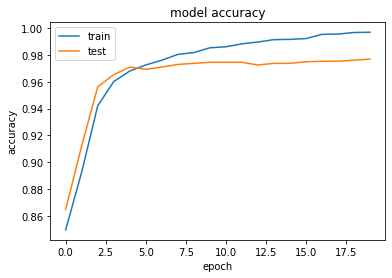

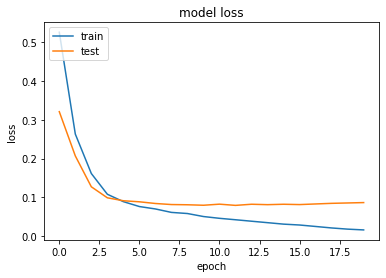

In [72]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()